## Example 1 - Triangulation of arbitrary points on the sphere

`stripy` provides a python interfact to STRIPACK and SSRFPACK (Renka 1997a,b) as a triangulation class that would typically be used as follows:

``` python

import stripy as stripy
spherical_triangulation = stripy.sTriangulation(lons=vertices_lon_as_radians, lats=vertices_lat_as_radians)
s_areas = spherical_triangulation.areas()
```

The methods of the `sTriangulation` class include interpolation, smoothing and gradients (from SSRFPACK), triangle areas, point location by simplex and nearest vertex, refinement operations by edge or centroid, and neighbourhood search / distance computations through a k-d tree algorithm suited to points on the surface of a unit sphere. `stripy` also includes template triangulated meshes with refinement operations.

In this notebook we introduce the `sTriangulation` class itself.

#### Notebook contents

   - [Icosahedron](#Triangulate-the-vertices-of-an-icosahedron)
   - [Plotting on a map](#Making-a-plot-of-the-triangulation)
   - [3D visualisation](#Lavavu-to-view-spherical-information)
   - [Predefined meshes](#Predefined-meshes)

#### References



 
   1. Renka, R. J. (1997), Algorithm 772: STRIPACK: Delaunay triangulation and Voronoi diagram on the surface of a sphere, ACM Transactions on Mathematical Software (TOMS).
   
   2. Renka, R. J. (1997), Algorithm 773: SSRFPACK: interpolation of scattered data on the surface of a sphere with a surface under tension, ACM Transactions on Mathematical Software (TOMS), 23(3), 435–442, doi:10.1145/275323.275330.
   
   3. Renka, R. J. (1996), Algorithm 751; TRIPACK: a constrained two-dimensional Delaunay triangulation package, ACM Transactions on Mathematical Software, 22(1), 1–8, doi:10.1145/225545.225546.
   
   4. Renka, R. J. (1996), Algorithm 752; SRFPACK: software for scattered data fitting with a constrained surface under tension, ACM Transactions on Mathematical Software, 22(1), 9–17, doi:10.1145/225545.225547.


The next example is [Ex2-SphericalGrids](./Ex2-SphericalGrids.ipynb)

## Triangulate the vertices of an icosahedron

In [ ]:
import stripy as stripy
import numpy as np

# Vertices of an icosahedron as Lat / Lon in degrees

vertices_LatLonDeg = np.array(
                               [[ 90,         0.0 ],
                                [ 26.57,      0.0 ],
                                [-26.57,     36.0 ],
                                [ 26.57,     72.0 ],
                                [-26.57,    108.0 ],
                                [ 26.57,    144.0 ],
                                [-26.57,    180.0 ],
                                [ 26.57,    360.0-72.0 ],
                                [-26.57,    360.0-36.0 ],
                                [ 26.57,    360.0-144.0 ],
                                [-26.57,    360.0-108.0 ],
                                [-90,         0.0 ]])


vertices_lat = np.radians(vertices_LatLonDeg.T[0])
vertices_lon = np.radians(vertices_LatLonDeg.T[1])

spherical_triangulation = stripy.sTriangulation(lons=vertices_lon, lats=vertices_lat)

This creates a triangulation object constructed using the wrapped fortran code of Renka (1997). The triangulation object has a number of 
useful methods and attached data which can be listed with

``` python

help(spherical_triangulation)
```


In [ ]:
print spherical_triangulation.areas()
print spherical_triangulation.npoints

In [ ]:
refined_spherical_triangulation = stripy.sTriangulation(lons=vertices_lon, lats=vertices_lat, refinement_levels=3)

print refined_spherical_triangulation.npoints

## Making a plot of the triangulation

We can make a plot of the two grids and the most straightforward way to display the information
is through a standard map projection of the sphere to the plane. 

(Here we superimpose the points on a global map of coastlines using the `cartopy` map library and use the Mollweide projection. 
 Other projections to try include `Robinson`, `Orthographic`, `PlateCarree`)

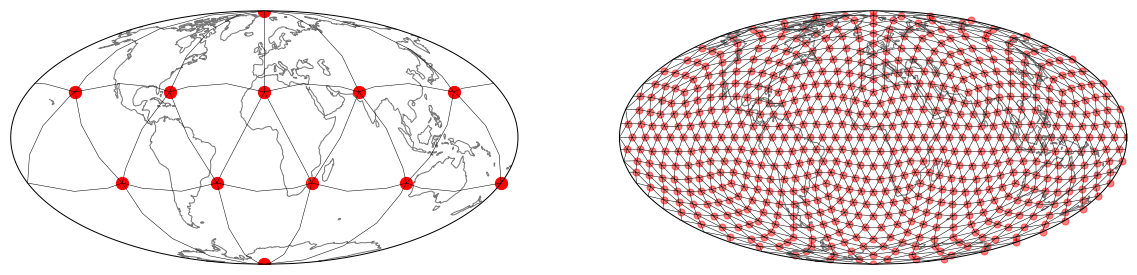

In [7]:
%matplotlib inline

import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(20, 10), facecolor="none")
    
ax  = plt.subplot(121, projection=ccrs.Mollweide(central_longitude=0.0, globe=None))
ax.coastlines(color="#777777")
ax.set_global()

ax2 = plt.subplot(122, projection=ccrs.Mollweide(central_longitude=0.0,  globe=None))
ax2.coastlines(color="#777777")
ax2.set_global()

## Plot the vertices and the edges for the original isocahedron

lons = np.degrees(spherical_triangulation.lons)
lats = np.degrees(spherical_triangulation.lats)

ax.scatter(lons, lats, color="Red",
                 marker="o", s=150.0, transform=ccrs.Geodetic())

segs = spherical_triangulation.identify_segments()

for s1, s2 in segs:
    ax.plot( [lons[s1], lons[s2]],
             [lats[s1], lats[s2]], 
              linewidth=0.5, color="black", transform=ccrs.Geodetic())


## Plot the vertices and the edges for the refined isocahedron

lons = np.degrees(refined_spherical_triangulation.lons)
lats = np.degrees(refined_spherical_triangulation.lats)

ax2.scatter(lons, lats, color="Red", alpha=0.5,
                 marker="o", s=50.0, transform=ccrs.Geodetic())


segs = refined_spherical_triangulation.identify_segments()

for s1, s2 in segs:
    ax2.plot( [lons[s1], lons[s2]],
              [lats[s1], lats[s2]], 
              linewidth=0.5, color="black", transform=ccrs.Geodetic())

### `Lavavu` to view spherical information

We can view the same triangulation in an interactive form using the `lavavu` package (`pip install lavavu`). 
The list of simplices of the triangulation (`spherical_triangulation.simplices`) is compatible with the format expected by Lavavu.




In [5]:
import lavavu

lv = lavavu.Viewer(border=False, resolution=[666,666], background="#FFFFFF")
lv["axis"]=False
lv['specular'] = 0.5

ghost = lv.triangles("ghost",  wireframe=False, colour="#777777", opacity=0.1)
ghost.vertices(refined_spherical_triangulation.points*0.99)
ghost.indices(refined_spherical_triangulation.simplices)

tris = lv.triangles("coarse",  wireframe=False, colour="#4444FF", opacity=0.8)
tris.vertices(spherical_triangulation.points)
tris.indices(spherical_triangulation.simplices)

trisw = lv.triangles("coarsew",  wireframe=True, colour="#000000", opacity=0.8, linewidth=3.0)
trisw.vertices(spherical_triangulation.points)
trisw.indices(spherical_triangulation.simplices)

nodes = lv.points("coarse_nodes", pointsize=10.0, pointtype="shiny", colour="#4444FF", opacity=0.95)
nodes.vertices(spherical_triangulation.points)

tris2 = lv.triangles("fine",  wireframe=False, colour="#007f00", opacity=0.25)
tris2.vertices(refined_spherical_triangulation.points)
tris2.indices(refined_spherical_triangulation.simplices)

tris2w = lv.triangles("finew",  wireframe=True, colour="#444444", opacity=0.25, linewidth=0.5)
tris2w.vertices(refined_spherical_triangulation.points)
tris2w.indices(refined_spherical_triangulation.simplices)

nodes2 = lv.points("fine_nodes", pointsize=3.0, pointtype="shiny", colour="FF0000", opacity=0.95)
nodes2.vertices(refined_spherical_triangulation.points)

lv.hide("fine")
lv.hide("finew")




In [6]:

lv.control.Panel()
lv.control.Button(command="hide triangles; hide points; show ghost; show fine_nodes; show coarse; show coarsew; show coarse_nodes; redraw", label="Coarse")
lv.control.Button(command="hide triangles; hide points; show ghost; show coarse_nodes; show fine; show finew; show fine_nodes; redraw", label="Fine")

lv.control.show()


<IPython.core.display.Javascript object>

## Predefined meshes

One common use of `stripy` is in meshing the sphere and, to this end, we provide pre-defined meshes for icosahedral and octahedral triangulations, each of which can have mid-face centroid points included. A triangulation of the six cube-vertices is also provided as well as a 'buckyball' mesh. The icosahedral meshes defined above can be created directly using:

``` python

spherical_triangulation         = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=0)
refined_spherical_triangulation = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3)
```

This capability is shown in a companion notebook [Ex2-SphericalGrids](./Ex2-SphericalGrids.ipynb)
